# Train a shallow SNN on the Randman Dataset

In [65]:
import sys

sys.path.append("../")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import stork.datasets
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup, DelayGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenCenteredNormalInitializer

import scipy.signal as signal

## Generate Dataset

Specify the Dataset Parameters

In [66]:
torch.manual_seed(12)
np.random.seed(12)


nb_inputs = 1
nb_time_steps = 120
nb_spikes = 1
nb_outputs = 1
dt = 2e-3

duration = nb_time_steps * dt

In [67]:
data = [(torch.tensor([10]), torch.tensor([0]))] * 10
labels = [(torch.tensor([30]), torch.tensor([0]))] * 10
# labels = [(torch.tensor([]), torch.tensor([]))]*10

In [68]:
ds_kwargs = dict(
    nb_steps=nb_time_steps, nb_units=nb_inputs, time_scale=1.0, target_units=nb_outputs
)

# Split into train, test and validation set
datasets = [
    stork.datasets.RasRasDataset(ds, **ds_kwargs)
    for ds in stork.datasets.split_dataset(
        data, labels, splits=[0.1, 0.1, 0.8], shuffle=False
    )
]
ds_train, ds_valid, ds_test = datasets

print(len(ds_train), len(ds_valid), len(ds_test))

1 1 8


In [69]:
tau_mem = 20e-3
tau_syn = 10e-3

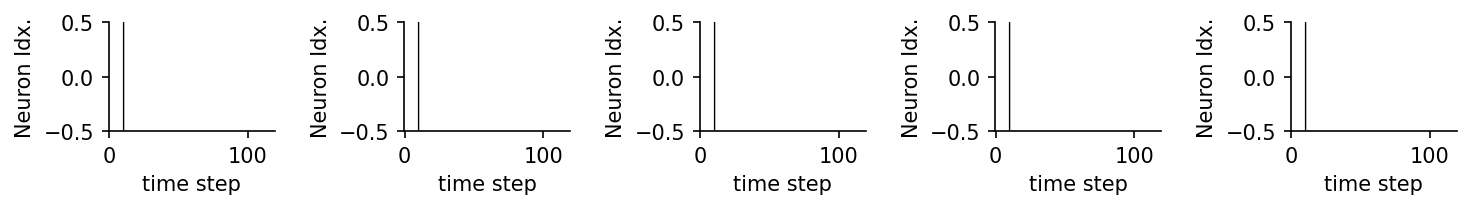

In [70]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5), dpi=150)
for i in range(5):
    ax[i].imshow(np.transpose(ds_test[i][0]), cmap="binary", aspect="auto")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("Neuron Idx.")
    # ax[i].set_title("label: " + str(ds_train[i][1]))

plt.tight_layout()
sns.despine()

## Set up the model

In [71]:
# Model Parameters
batch_size = 1
beta = 20
device = torch.device("cpu")
dtype = torch.float


nb_hidden_units = 1

lr = 10
nb_epochs = 50

In [72]:
act_fn = stork.activations.CustomSpike

act_fn.beta = beta
neuron_group = LIFGroup

model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Add neuron groups

In [73]:
input_group = model.add_group(InputGroup(nb_inputs))
hidden_neurons = model.add_group(
    LIFGroup(nb_hidden_units, tau_mem=tau_mem, tau_syn=tau_syn, activation=act_fn)
)

readout_group = delay_neurons = model.add_group(
    DelayGroup(
        src=hidden_neurons,
        max_delay_timesteps=nb_time_steps // 2,
    )
)

Add synapses between the neuron groups

In [74]:
con = model.add_connection(Connection(input_group, hidden_neurons))

Add regularizers

In [75]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = (
    4  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)

# Define regularizer list
regs = []

regLB = stork.regularizers.LowerBoundL2(
    lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
)
regs.append(regLB)
regUB = stork.regularizers.UpperBoundL2(
    upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1
)
regs.append(regUB)

# Add to neurons
hidden_neurons.regularizers.extend(regs)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [76]:
con.op.weight = torch.nn.Parameter(torch.tensor([[5.0]]))
print(con.op.weight)

Parameter containing:
tensor([[5.]], requires_grad=True)


In [77]:
for g in model.groups:
    print(g.name)
    if "Delay" in g.name:
        g.delays = torch.nn.Parameter(torch.tensor([25.0001]))

Input
LIFGroup
DelayGroup


Add monitors for spikes and membrane potential

In [78]:
for g in model.groups:
    print(g.name)

Input
LIFGroup
DelayGroup


In [79]:
model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1]))
model.add_monitor(stork.monitors.StateMonitor(model.groups[1], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

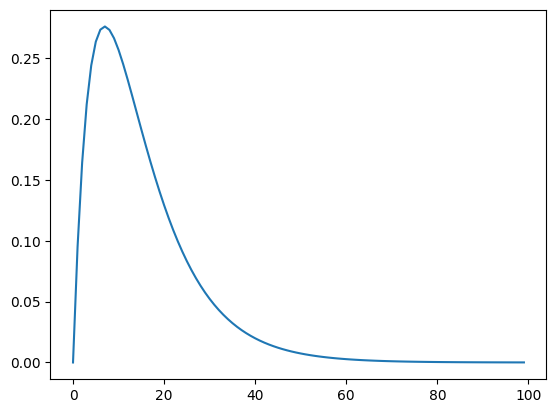

In [80]:
lif_kernel = torch.tensor(stork.utils.get_lif_kernel(tau_mem, tau_syn, dt), dtype=dtype)
# lif_kernel = lif_kernel.flip(0)
plt.plot(lif_kernel)
loss_stack = stork.loss_stacks.vRD_MeanSquareError(kernel=lif_kernel)

We select the SMORMS3 optimizer

In [81]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [82]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
)

Before we train the model, we monitor the spikes

In [83]:
# Monitors spike counts before training
res = model.monitor(ds_test)
total_spikes = torch.sum(res[0]).item()

results = {}
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(1)]
results["avg_layer_freq_init"] = [
    nb / len(ds_test) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

print(results)

{'avg_layer_freq_init': [4.166666666666667]}


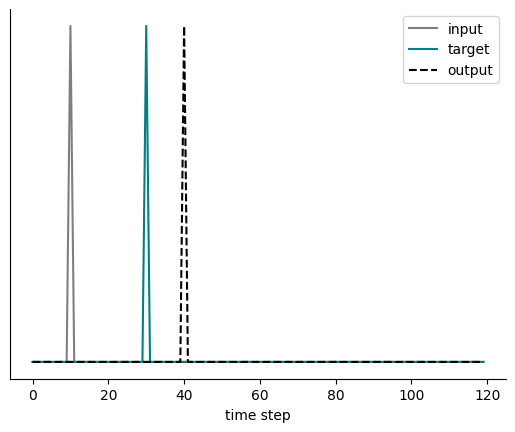

In [84]:
pred = model.predict(ds_train)
plt.plot(ds_train[0][0], color="k", alpha=0.5, label="input")
plt.plot(ds_train[0][1], color="teal", label="target")
plt.plot(pred[0], "--", color="k", label="output")
plt.legend()
plt.xlabel("time step")
plt.yticks([])
sns.despine()


## Training

takes around 13-20 minutes

In [85]:
for name, param in model.named_parameters():
    print(name, end="")
    if "weight" in name:
        # do not require grad
        param.requires_grad = False
        print(param.requires_grad, ": no grad")
    else:
        print()

group3.delays
con1.op.weightFalse : no grad


In [86]:
print(delay_neurons.delays)

Parameter containing:
tensor([25.0001], requires_grad=True)


In [87]:
history = model.fit_validate(ds_train, ds_valid, nb_epochs=nb_epochs, verbose=True)

00  loss=0.00128 reg_loss=0 -- val_loss=0.0011 val_reg_loss=0 t_iter=0.26
01  loss=0.0011 reg_loss=0 -- val_loss=0.000914 val_reg_loss=0 t_iter=0.24
02  loss=0.000914 reg_loss=0 -- val_loss=0.000914 val_reg_loss=0 t_iter=0.20
03  loss=0.000914 reg_loss=0 -- val_loss=0.000737 val_reg_loss=0 t_iter=0.20
04  loss=0.000737 reg_loss=0 -- val_loss=0.000569 val_reg_loss=0 t_iter=0.22
05  loss=0.000569 reg_loss=0 -- val_loss=0.000414 val_reg_loss=0 t_iter=0.23
06  loss=0.000414 reg_loss=0 -- val_loss=0.000276 val_reg_loss=0 t_iter=0.19
07  loss=0.000276 reg_loss=0 -- val_loss=0.000161 val_reg_loss=0 t_iter=0.28
08  loss=0.000161 reg_loss=0 -- val_loss=7.41e-05 val_reg_loss=0 t_iter=0.29
09  loss=7.41e-05 reg_loss=0 -- val_loss=1.9e-05 val_reg_loss=0 t_iter=0.30
10  loss=1.9e-05 reg_loss=0 -- val_loss=1.9e-05 val_reg_loss=0 t_iter=0.33
11  loss=1.9e-05 reg_loss=0 -- val_loss=0 val_reg_loss=0 t_iter=0.34
12  loss=0 reg_loss=0 -- val_loss=0 val_reg_loss=0 t_iter=0.32
13  loss=0 reg_loss=0 -- val_

In [88]:
for key, val in history.items():
    if key in results:
        results[key] += val.tolist()
    else:
        results[key] = val.tolist()

In [89]:
print(delay_neurons.delays)

Parameter containing:
tensor([15.4082], requires_grad=True)


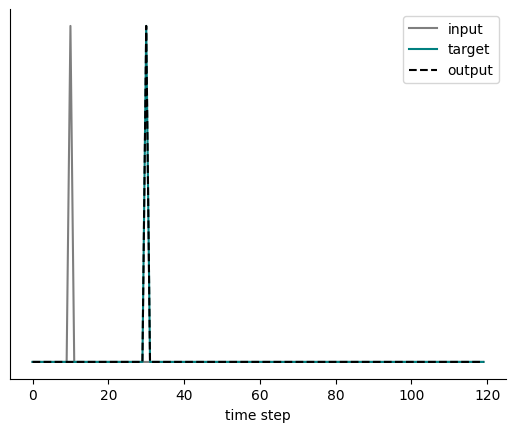

In [90]:
pred = model.predict(ds_train)
plt.plot(ds_train[0][0], color="k", alpha=0.5, label="input")
plt.plot(ds_train[0][1], color="teal", label="target")
plt.plot(pred[0], "--", color="k", label="output")
plt.legend()
plt.xlabel("time step")
plt.yticks([])
sns.despine()


In [91]:
for g in model.groups:
    try:
        print(g.name, g.delays.grad)
    except:
        print(g.name)

Input
LIFGroup
DelayGroup tensor([0.])


In [92]:
print(delay_neurons.delays)

Parameter containing:
tensor([15.4082], requires_grad=True)


#### Monitor the model again after training

In [93]:
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(1)]
results["avg_layer_freq"] = [
    nb / len(ds_test) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

## Test

In [94]:
scores = model.evaluate(ds_test).tolist()
print(scores)

[0.0, 0.0]


In [95]:
l, a = scores
if "test_loss" in results:
    results["test_loss"].append(l)
    results["test_acc"].append(a)
else:
    results["test_loss"] = [l]
    results["test_acc"] = [a]

Test loss:  0.0
Test acc.:  0.0 %


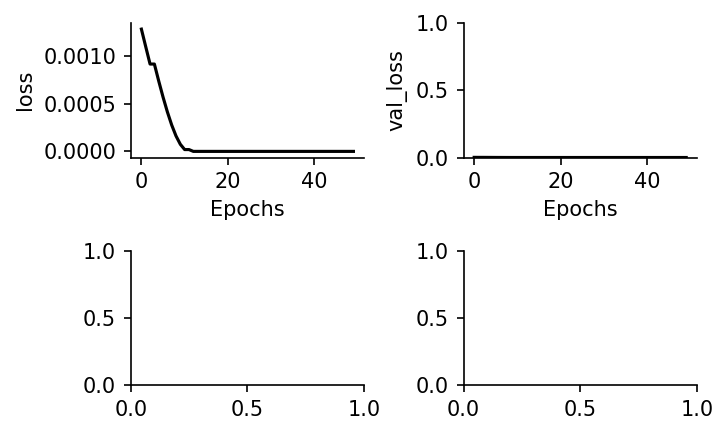

In [96]:
fig, ax = plt.subplots(2, 2, figsize=(5, 3), dpi=150)

for i, n in enumerate(
    [
        "loss",
        "val_loss",
    ]
):

    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i - 2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"][-1])
print("Test acc.: ", round(results["test_acc"][-1] * 100, 2), "%")